<a href="https://colab.research.google.com/github/Prakartt/Customer-Segmentation-and-Stock-market-prediction-for-portfolio-generation-/blob/main/Stockpred_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<h2>PART 1. Data Pre-processing</h2>

In [3]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

<h3>Step #1. Read data</h3>

In [4]:
# Importing Training Set
dataset_train = pd.read_csv('/content/GOOG.csv')
df=dataset_train
# dataset_train = np.expand_dims(np.arange(4006,7), axis=1)

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[4:]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))


Training set shape == (4494, 7)
All timestamps == 4494
Featured selected: ['Close', 'Adj Close', 'Volume']


<h3>Step #2. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [5]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (4494, 3).


array([[4.99826550e+01, 4.99826550e+01, 4.48713610e+07],
       [5.39527700e+01, 5.39527700e+01, 2.29428740e+07],
       [5.44957350e+01, 5.44957350e+01, 1.83428970e+07],
       ...,
       [2.24067993e+03, 2.24067993e+03, 1.19610000e+06],
       [2.25368994e+03, 2.25368994e+03, 1.23550000e+06],
       [2.37076001e+03, 2.37076001e+03, 1.95470000e+06]])

In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.98208107],
       [-0.97620821],
       [-0.97540502],
       ...,
       [ 2.25854308],
       [ 2.27778834],
       [ 2.45096612]])

In [ ]:
print(len(training_set_scaled))

4494


In [7]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want to predict into the future
n_past = 1825    # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i:i+n_future,0 ])
#i:i+n_future,0  or i + n_future - 1:i + n_future, 0
# X_train = np.expand_dims(np.arange(1452, 1825, 4), axis=1)
# Y_train = np.expand_dims(np.arange(1452, 1), axis=1)

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (2610, 1825, 2).
y_train shape == (2610, 60).


<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [8]:
# Import Libraries and packages from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam


In [9]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=64, return_sequences=True))
#Adding 3rd LSTM layer
model.add(LSTM(units=10, return_sequences=False))
# Adding Dropout
model.add(Dropout(0.20))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.03), loss='mean_squared_error')

<h3>Step #4. Start training</h3>

In [12]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=50, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.2200 
Epoch 1: val_loss improved from inf to 5.02522, saving model to weights.h5
9/9 [==============================] - 150s 17s/step - loss: 0.2200 - val_loss: 5.0252 - lr: 0.0300
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.2208 
Epoch 2: val_loss did not improve from 5.02522
9/9 [==============================] - 146s 16s/step - loss: 0.2208 - val_loss: 5.2899 - lr: 0.0300
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.2193 
Epoch 3: val_loss did not improve from 5.02522
9/9 [==============================] - 156s 17s/step - loss: 0.2193 - val_loss: 5.1910 - lr: 0.0300
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.2191 
Epoch 4: val_loss did not improve from 5.02522
9/9 [==============================] - 149s 17s/step - loss: 0.2191 - val_loss: 5.2477 - lr: 0.0300
Epoch 5/50
9/9 [==============================] - ETA: 0s - loss: 0.2188 
Epoch 5: val_l

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

<h2>PART 3. Make future predictions</h2>

In [13]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

<h3>Step #5. Make predictions for future dates</h3>

In [14]:
model.compile(run_eagerly=True)

In [15]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [16]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Close']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)
PREDICTIONS_FUTURE
#PREDICTION_TRAIN.head(3)

,Close
2016-12-07,759.291565
2016-12-08,759.278198
2016-12-09,759.156616
2016-12-10,759.133606
2016-12-11,759.110352
2016-12-12,759.129822
2016-12-13,759.155334
2016-12-14,759.188904
2016-12-15,759.152222
2016-12-16,759.160767


<h3>Step #6. Visualize the Predictions</h3>

In [ ]:
dataset_train

,Close,Adj Close,Volume
0,49.982655,49.982655,44871361.0
1,53.952770,53.952770,22942874.0
2,54.495735,54.495735,18342897.0
3,52.239197,52.239197,15319808.0
4,52.802086,52.802086,9232276.0
...,...,...,...
4489,2157.310059,2157.310059,2163500.0
4490,2240.300049,2240.300049,1950500.0
4491,2240.679932,2240.679932,1196100.0
4492,2253.689941,2253.689941,1235500.0


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2016-12-07 to 2017-02-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   60 non-null     float32
dtypes: float32(1)
memory usage: 720.0 bytes


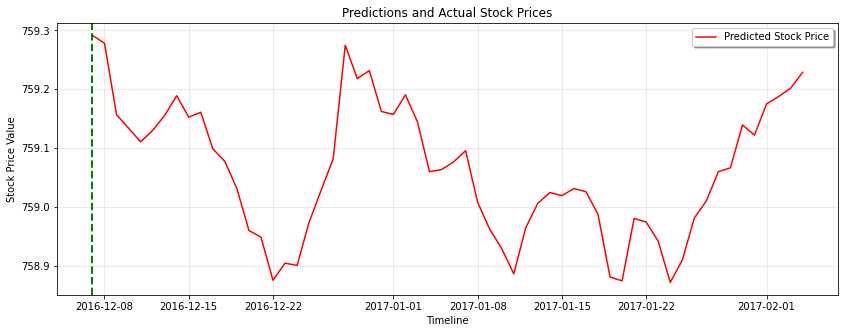

In [17]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5


PREDICTIONS_FUTURE.info()

# Plot parameters
START_DATE_FOR_PLOTTING = '2014-01-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Close'], color='r', label='Predicted Stock Price')
#plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Close'], color='orange', label='Training predictions')
#plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:]['Date'], dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)

plt.show()

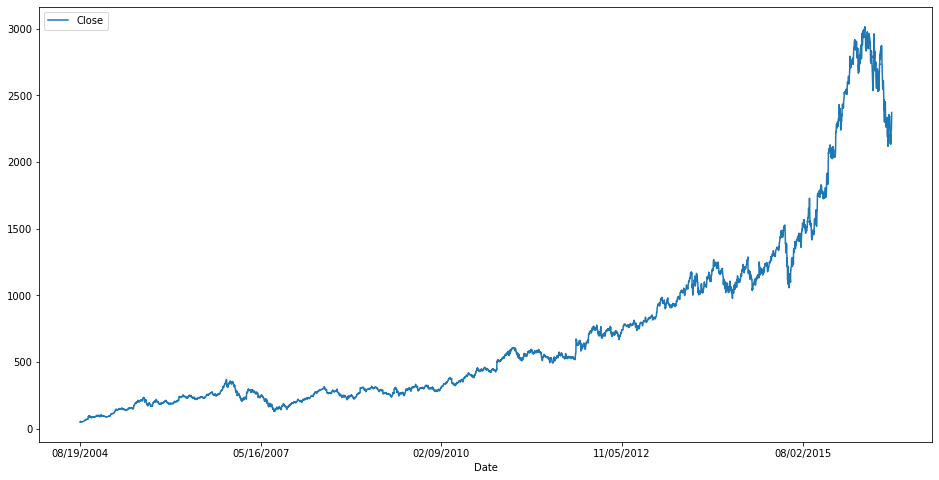

In [18]:

df.plot.line(x='Date', y='Close', figsize=(16,8))